<!-- PELICAN_BEGIN_SUMMARY -->

Using only 1 factor (Vegas line), we will try to calculate the probability associated with a college football team winning the game using Python and StatsModels. The Vegas Line provides a model with minimal bias, and a very good use case to show Logistic Regression in Practice.

<!-- PELICAN_END_SUMMARY -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

We will start by loading the games from 2007-2016

In [2]:
ncaa_games = pd.read_csv('./data/ncaa2007-2016.csv')
ncaa_games[['Home', 'Road', 'line', 'hscore', 'vscore']].head()

,Home,Road,line,hscore,vscore
0,Arizona,Idaho,27.0,70.0,0.0
1,Army,Temple,-7.5,7.0,35.0
2,Auburn,Louisiana-Monroe,26.0,34.0,0.0
3,Baylor,Wake Forest,-11.5,13.0,41.0
4,Buffalo,UTEP,3.0,42.0,17.0


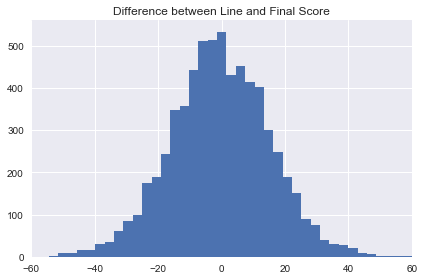

Mean: -0.45
Standard Deviation: 15.57


In [3]:
ncaa_games['spread_diff'] = ncaa_games.score_diff - ncaa_games.line
plt.hist(ncaa_games.spread_diff, bins=40)
plt.title('Difference between Line and Final Score')
plt.xlim([-60, 60])
plt.tight_layout()
plt.show()
print('Mean: %.2f' % 
      np.mean(ncaa_games.score_diff-ncaa_games.line))
print('Standard Deviation: %.2f' % 
      np.std(ncaa_games.score_diff-ncaa_games.line, ddof=1))

There doesn't seem to be much bias, but there seems to be a decent amount of variation. Here is a look at the games where the spread and the actual score difference was not very close:

In [4]:
ncaa_games[abs(ncaa_games.spread_diff)>50][
    ['Home',
     'Road',
     'line',
     'hscore',
     'vscore']]

,Home,Road,line,hscore,vscore
88,BYU,UCLA,8.5,59.0,0.0
260,Tulane,Army,20.0,13.0,44.0
1027,Kansas St.,Texas A&M,-5.0,62.0,14.0
2276,UAB,Tulane,13.0,10.0,49.0
2879,Houston,Texas St.,36.0,13.0,30.0
3366,UCLA,Arizona,3.0,66.0,10.0
5046,Ohio St.,Wisconsin,-4.5,59.0,0.0
5265,Oregon,Utah,12.5,20.0,62.0
5417,Kansas St.,Oklahoma,-4.5,0.0,55.0
5479,Miami (Fla.),Clemson,-7.5,0.0,58.0


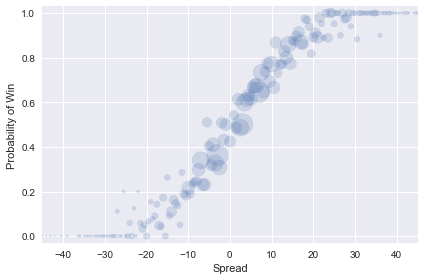

In [5]:
by_line = ncaa_games[['Home_Win', 'line']].groupby(
    ['line']).agg(['mean', 'count'])['Home_Win']
plt.scatter(x=by_line.index, 
            y = by_line['mean'], 
            s = by_line['count']*2, 
            alpha = .2)
plt.xlim([-45, 45])
plt.ylim([-.03, 1.03])
plt.xlabel('Spread')
plt.ylabel('Probability of Win')
plt.tight_layout()
plt.show()

# Looks very similar to the logistic function

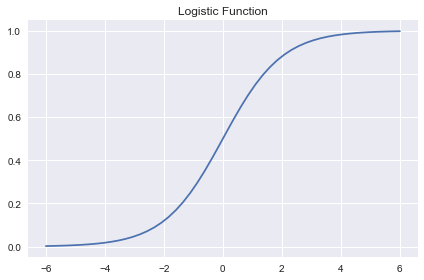

In [6]:
def logistic_function(x):
    return 1/(1+np.exp(-x))

x=np.linspace(-6,6)
y=logistic_function(x)

plt.plot(x,y)
plt.title('Logistic Function')
plt.tight_layout()
plt.show()

In [7]:
X= pd.DataFrame(data={'intercept': 1, 'line': ncaa_games['line']})
y= ncaa_games.Home_Win

In [8]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.491849
         Iterations 6


In [9]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Home_Win   No. Observations:                 6568
Model:                          Logit   Df Residuals:                     6566
Method:                           MLE   Df Model:                            1
Date:                Mon, 08 May 2017   Pseudo R-squ.:                  0.2770
Time:                        15:37:05   Log-Likelihood:                -3230.5
converged:                       True   LL-Null:                       -4468.3
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1212      0.032     -3.808      0.000      -0.184      -0.059
line           0.1259      0.003     37.485      0.000       0.119       0.132
==============================================================================
"""

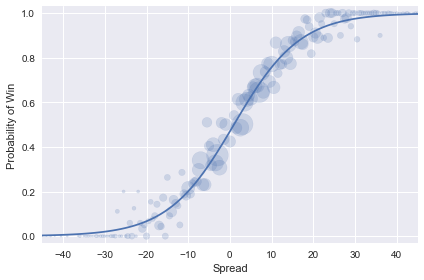

In [10]:
pred_x =pd.DataFrame(data=
                     {'intercept': 1, 
                      'line': np.linspace(X.line.min(),
                                          X.line.max(), 
                                          100)})
pred_y = result.predict(pred_x)
plt.scatter(x=by_line.index, 
            y = by_line['mean'], 
            s = by_line['count']*2, 
            alpha = .2)
plt.xlim([-45, 45])
plt.ylim([-.03, 1.03])
plt.xlabel('Spread')
plt.ylabel('Probability of Win')
plt.plot(pred_x.line, pred_y)
plt.tight_layout()
plt.show()

In [11]:
def compute_win_proba(spread, model):
    return model.predict([1,spread])[0]

print('Win Probability when team is favored by 6 points:\n%.2f' % 
      compute_win_proba(6, result))

Win Probability when team is favored by 6 points:
0.65
